# Quantity Theory of Money Data

This program produces two data sets that can be used to assess the predictions of the quantity theory of money in closed and open economy settings.

## Background

**The quantity theory.** The primary implication of the quantity theory of money is that the average inflation rate for some country $k$ will equal the average growth rate of its money supply less the average growth rate of its real GDP:

\begin{align}
\pi_k & = g^M_k - g^Y_k
\end{align}

Holding the growth rate of real GDP constant, a one percentage point increase in average money growth implies a one percentage point increase in average inflation.

**The Fisher effect.** Next, combining the quantity theory with the Fisher equation and assuming equal real interest rates across countries, the difference between the nominal interest rate of country $k$ and the nominal interest rate of the US is equal to the difference in the average 

\begin{align}
i_k - i_{US} & = \pi_k - \pi_{US}\\
             & = (g^M_k - g^M_{US}) - (g^Y_k - g^Y_{US})\\
             & \approx g^M_k - g^M_{US}
\end{align}

where the final line follows because the average growth rate of real GDP for the US is close to the world average. Holding the growth rate of real GDP constant, a one percentage point increase in average money growth for country $k$ implies a one percentage point increase in the average nominal interest rate in country $k$ relative to the US.

**Relative PPP.** Finally, combining the quantity theory with purchasing power parity, the average depreciation of the exchange rate of the currency of country $k$ relative to the the US dollar equals the average inflation differential between the US and the 

\begin{align}
g^E_k & = \pi_k - \pi_{US} \\
      & = (g^M_{k} - g^M_{US}) - (g^Y_k - g^Y_{US})\\
     & \approx g^M_{k} - g^M_{US}
\end{align}

where the nominal exchange rate $E_k$ has units of the country $k$ currency per US dollar. Holding the growth rate of real GDP constant, a one percentage point increase in average money growth for country $k$ implies a one percentage point increase in the average rate of deprecitation in the exchange for the currency of country $k$ relative to the US dollar. See, for example the discussion in Chapter 14 of Feenstra and Taylor (2021).


## Output

The first file is called `quantity_theory_data.csv` and contains the following data columns for about 160 countries:

Column name  | Description                                        |
-------------|----------------------------------------------------|
country      | Country name                                       |
iso code     | 3-letter ISO code                                  |
observations | Number of consecutive years of observations        |
money growth | Average growth rate of broad money supply          |
inflation    | Average growth rate of nominal                     |
gdp growth   | Average growth rate of real GDP                    |
income group | Whether country is high, middle, or low income     |
oecd         | Whether the country is in the OECD                 |


The second file, `quantity_theory_data_open.csv`, contains the same columns as the first and additionally:

Column name                | Description                                        |
---------------------------|----------------------------------------------------|
nominal interest rate	   | Average lending rate                               |
exchange rate depreciation | Average growth of exchange rate                    |

The files are stored in the `..\csv` directory.

## Construction

Raw data are from the World Bank's World Development Indicators (WDI, https://datatopics.worldbank.org/world-development-indicators/). These data are obtained:

WDI ID         | Name                                       |
---------------|--------------------------------------------|
FM.LBL.BMNY.CN | Broad money (current LCU)                  |
NY.GDP.DEFL.ZS | GDP deflator (base year varies by country) |
NY.GDP.MKTP.KD | GDP (constant 2015 US\\$)                  |
PA.NUS.FCRF    | Official exchange rate (LCU per US\\$)     |
FR.INR.LEND    | Lending interest rate (%)                  |

For each country, I find the largest date range that contains consecutive non-NaN values for the required indicators, either the first three or all five. Then if there is at least 10 years of data available, I compute the required averages.

## Further reading

Read more about empirical applications of the quantity theory:

* Feenstra, Robert C. and Alan M. Taylor. 2021. *International Economics* 5th ed.

* McCandless, George and Warren Weber. 1995. "Some Monetary Facts" Federal Reserve Bank of Minneapolis *Quarterly Review*. (https://www.minneapolisfed.org/research/qr/qr1931.pdf)

* Dwyer, Gerald P. and R.W. Hafer. 1999. "Are Money Growth and Inflation Still Related?" Federal Reserve Bank of
Atlanta *Economic Review*. (https://fraser.stlouisfed.org/title/economic-review-federal-reserve-bank-atlanta-884/second-quarter-1999-601600/money-growth-inflation-still-related-581622)


## Preliminaries

In [1]:
# Load modules
import pandas as pd
import numpy as np
import wbdata
import os
import requests
import zipfile
import matplotlib.pyplot as plt
plt.style.use('classic')

%matplotlib inline

# OECD countries
oecd_list = ['AUS','AUT','BEL','CAN','CHL','CZE','DNK','EST','FIN','FRA','DEU','GRC','HUN','ISL','IRL','ISR',
             'ITA','JPN','KOR','LUX','MEX','NLD','NZL','NOR','POL','PRT','SVK','SVN','ESP','SWE','CHE','TUR',
             'GBR','USA']

# List of region and category codes to be droppped
drop_list = ['AFE','AFR','AFW','ARB','BEA','BEC','BHI','BLA','BMN','BSS','CAA','CEA','CEB','CEU',
             'CLA','CME','CSA','CSS','DEA','DEC','DFS','DLA','DMN','DNF','DNS','DSA','DSF','DSS',
             'EAP','EAR','EAS','ECA','ECS','EMU','EUU','FCS','FXS','HIC','HPC','IBB','IBD','IBT',
             'IDA','IDB','IDX','INX','LAC','LCN','LDC','LIC','LMC','LMY','LTE','MDE','MEA','MIC',
             'MNA','NAC','NAF','NRS','NXS','OED','OSS','PRE','PSS','PST','RRS','SAS','SSA','SSF',
             'SST','SXZ','TEA','TEC','TLA','TMN','TSA','TSS','UMC','WLD','XZN']

# Dictionary of required indicators
indicators = {
    'FM.LBL.BMNY.CN':'broad money',
    'NY.GDP.DEFL.ZS':'gdp deflator',
    'NY.GDP.MKTP.KD':'real gdp',
    'PA.NUS.FCRF':'exchange rate',
    'FR.INR.LEND':'lending rate'
}

## Import data using `wbpy`

In [2]:
# Get all countries and regions available through WB API
all_wb_countries = wbdata.get_country()

# Convert to a DataFrame with selected columns
countries_and_regions = pd.DataFrame()

for c in all_wb_countries:
    countries_and_regions.loc[c['id'],'country name'] = c['name']
    countries_and_regions.loc[c['id'],'income group'] = c['incomeLevel']['id']

# Change income abbreviations to words
countries_and_regions = countries_and_regions.replace('HIC','high').replace('UMC','middle').replace('LMC','middle').replace('LIC','low')

# Name the index
countries_and_regions.index.name = 'iso code'

# # Print all countries and regions
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(countries_and_regions)

In [3]:
# Series of only countries
countries = countries_and_regions[~countries_and_regions.index.isin(drop_list)].copy()

# Identify which countries are in OECD
countries['oecd'] = 'no'
countries.loc[oecd_list,'oecd'] = 'yes'

# Series of only regions
regions = countries_and_regions[countries_and_regions.index.isin(drop_list)].copy()

# Print all countries
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(countries)
    
# Print all non-country regions
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(regions)

len(countries)

218

In [4]:
# Import data into a DataFrame
df=wbdata.get_dataframe(indicators,country=list(countries.index),keep_levels=False)

# Sort the index
df = df.sort_index()

# Set 1960 value of money for Chile to NaN if value is 0
if df.loc[('Chile','1960'),'broad money'] == 0:
    df.loc[('Chile','1960'),'broad money'] = np.nan
    
# Set 2018 value of lending rate for New Zealand to NaN if value is 0
if df.loc[('New Zealand','2018'),'lending rate'] == 0:
    df.loc[('New Zealand','2018'),'lending rate'] = np.nan

# Print the county, indicator, date combinations for which the indicator is 0
for col in df.columns:
    if len(df[df[col]==0][col])>0:
        print(df[df[col]==0][col])
        print()

## Import data by downloading all WDI indicators

This section is only here in case wbpy becomes unusable. Downloads `WDI_csv.zip` and extracts in the current directory. The following files are extracted:

* `WDISeries.csv`
* `WDISeries-Time.csv`
* `WDIFootNote.csv`
* `WDIData.csv`
* `WDICountry.csv`
* `WDICountry-Series.csv`


In [5]:
# # Download World Bank WDI data
# url = "http://databank.worldbank.org/data/download/WDI_csv.zip"

# file_name = "WDI_csv.zip"
# u = requests.get(url)

# with open(file_name, 'wb') as f:
#     for chunk in u.iter_content(chunk_size=1024): 
#         if chunk: # filter out keep-alive new chunks
#             f.write(chunk)
#             f.flush()
# f.close()

# fh = open('WDI_csv.zip', 'rb')
# z = zipfile.ZipFile(fh)
# z.extractall()

# # Delete zip file from WDI after extracting
# os.remove('WDI_csv.zip')

In [6]:
# # Load country data
# countries = pd.read_csv('WDICountry.csv')

# # Series of only countries
# countries = countries[~countries['Country Code'].isin(drop_list)]

# # Set ISO codes as index
# countries.index = countries['Country Code']
# countries.index.name = 'iso code'

# # Select only name and income group columns and rename
# countries = countries[['Table Name','Income Group']]
# countries.columns = ['country name','income group']

# # Change income abbreviations to words
# countries.loc[:,'income group'] = countries['income group'].str.replace('High income','high').copy()
# countries.loc[:,'income group'] = countries['income group'].str.replace('Upper middle income','middle').copy()
# countries.loc[:,'income group'] = countries['income group'].str.replace('Lower middle income','middle').copy()
# countries.loc[:,'income group'] = countries['income group'].str.replace('Low income','low').copy()

# # Identify which countries are in OECD
# countries['oecd'] = 'no'
# countries.loc[oecd_list,'oecd'] = 'yes'

# # Load indicator data
# df_raw = pd.read_csv('WDIData.csv')

# # Drop regions
# df_raw = df_raw[df_raw['Country Code'].isin(countries.index)]

# # Drop country code and indicator name
# df_raw= df_raw.drop(['Country Code','Indicator Name'],axis=1)

# # Drop unnecessary indicators
# df_raw = df_raw[df_raw['Indicator Code'].isin(indicators.keys())]

# # Drop superfluous unnamed columns
# columns_to_drop = []

# for c in df_raw.columns:
#     if 'unnamed' in c.lower():
#         columns_to_drop.append(c)
# df_raw = df_raw.drop(columns_to_drop,axis=1)

# # Replace indicator codes with names
# for key,value in indicators.items():
    
#     df_raw.loc[:,'Indicator Code'] = df_raw['Indicator Code'].str.replace(key,value,regex=False)

# # Empty DataFrame with county, year multiindex
# df = pd.DataFrame(index=pd.MultiIndex.from_product([df_raw['Country Name'].unique(),df_raw.columns[2:]],names=['country','date']))
# df = df.sort_index()

# # Iterate over rows of df_raw and fill values in df
# for i in df_raw.index:
#     for c in df_raw.columns[2:]:
        
#         df.loc[(df_raw.loc[i,'Country Name'],c),df_raw.loc[i,'Indicator Code']] = df_raw.loc[i,c]

# # Reorder columns
# df = df[['broad money','gdp deflator','real gdp','exchange rate','lending rate']]

# # Remove WDI csv files
# for file in os.listdir():
#     if file.endswith('csv') or file.endswith('zip'):
#         os.remove(file)

## Construct data sets

In [7]:
def get_limits(series):
    
    '''Function to extract longest run of non NaN values. Code adapted from: https://stackoverflow.com/a/41494706'''
    
    # Extract out relevant column from dataframe as array
    values = series.values
    
    # Mask
    mask = np.concatenate(( [True], np.isnan(values), [True] ))
    
    # Start-stop limits
    limits = np.flatnonzero(mask[1:] != mask[:-1]).reshape(-1,2)
    
    # Get max interval, interval limits
    start,stop = limits[(limits[:,1] - limits[:,0]).argmax()]
    
    return start,stop


def get_data_frame(df,indicators,show_not_available=False):
    
    '''Produce a DataFrame with the desired indicators'''
    
    data = pd.DataFrame()
    new_columns = pd.Series(
        ['money growth','inflation','gdp growth','exchange rate depreciation','nominal interest rate'],
        index=['broad money','gdp deflator','real gdp','exchange rate','lending rate']
    )
    
    for n, value in enumerate(df.groupby(level=0)):
        country, country_df = value
        
        try:
            
            column_sum = country_df[indicators].sum(axis=1,skipna=False)
            start,stop = get_limits(column_sum)
            
            if stop-start>=10:
                data.loc[n,'country'] = country
                try:
                    data.loc[n,'iso code'] = countries[countries==country].index[n]
                except:
                    print('Cannot find iso code for '+country)
                data.loc[n,'observations'] = stop - start
                
                
                for ind in indicators:
                    
                    if ind == 'lending rate':
                        
                        data.loc[n,new_columns[ind]] = np.mean(country_df[ind].iloc[start:stop])/100

                    else:    
                        data.loc[n,new_columns[ind]] = (country_df[ind].iloc[stop-1]/country_df[ind].iloc[start])**(1/(stop-start-1))-1
            
                data.loc[n,'income group'] = countries[countries['country name']==country]['income group'][0]
                data.loc[n,'oecd'] = countries[countries['country name']==country]['oecd'][0]
        except:
            if show_not_available==True:
                print('Data not available for: ',country)
            

    return data

# Closed economy data
quantity_theory_data = get_data_frame(df,indicators = ['broad money','gdp deflator','real gdp'],show_not_available=False)

# Export
quantity_theory_data.to_csv('../csv/quantity_theory_data.csv',index=False)

# Open economy data
quantity_theory_data_open = get_data_frame(df,indicators = ['broad money','gdp deflator','real gdp','lending rate','exchange rate'],show_not_available=False)

# Export
quantity_theory_data_open.to_csv('../csv/quantity_theory_data_open.csv',index=False)

## Figures

FileNotFoundError: [Errno 2] No such file or directory: '../png/money_inflation_by_income.png'

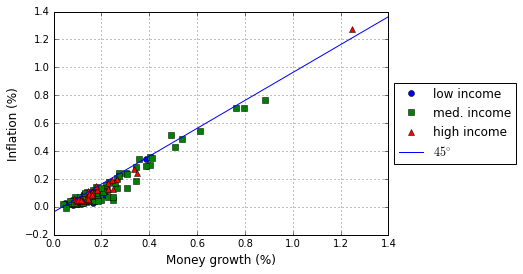

In [8]:
# Figure for my website
p_low = quantity_theory_data[quantity_theory_data['income group']=='low']['inflation']
m_low = quantity_theory_data[quantity_theory_data['income group']=='low']['money growth']
p_medium = quantity_theory_data[quantity_theory_data['income group']=='middle']['inflation']
m_medium = quantity_theory_data[quantity_theory_data['income group']=='middle']['money growth']
p_high = quantity_theory_data[quantity_theory_data['income group']=='high']['inflation']
m_high = quantity_theory_data[quantity_theory_data['income group']=='high']['money growth']

fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)

ax.plot(m_high,p_high,'bo',label='low income')
ax.plot(m_medium,p_medium,'gs',label='med. income')
ax.plot(m_low,p_low,'r^',label='high income')

xlim = ax.get_xlim()
ylim = ax.get_ylim()

ax.set_xlabel('Money growth (%)',fontsize=12)
ax.set_ylabel('Inflation (%)',fontsize=12)

ax.plot(xlim,np.array(xlim)-quantity_theory_data['gdp growth'].mean(),'b-',label='$45^{\\circ}$')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),numpoints=1)

ax.grid(linestyle=':')

plt.savefig('../png/money_inflation_by_income.png',bbox_inches='tight',dpi=120)

In [ ]:
quantity_theory_data

In [ ]:
p = quantity_theory_data['inflation']
m = quantity_theory_data['money growth']
codes = quantity_theory_data['iso code']
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)
# ax1.plot(p_pred,p_pred,lw=1.5,label='OLS Regression')
# ax1.legend(loc='lower right',fontsize=12)
for i in quantity_theory_data.index:
    

    
    if codes[i] =='USA':
        usa_index = i
#         plt.text(m[i], p[i], codes[i], color='red',fontsize=12, clip_on=True,horizontalalignment='center',verticalalignment='center',alpha = 1)
    else:
        plt.text(m[i], p[i], codes[i], color="#11557c",fontsize=12, clip_on=True,horizontalalignment='center',verticalalignment='center',alpha = 0.5)
plt.text(m[usa_index], p[usa_index], codes[usa_index], color='red',fontsize=12, clip_on=True,horizontalalignment='center',verticalalignment='center',alpha = 1)
# ax1.axis([-0.2, 1.4, -0.2, 1.4])
# ax1.set_xlabel('money growth')
# ax1.set_ylabel('inflation')
# plt.grid()

# plt.tight_layout()
# # plt.savefig('../png/fig_money_inflation_coded.png',bbox_inches='tight',dpi=120)

In [ ]:
# # 4.2 Money growth and inflation

# xmin = -0.05
# xmax = 1.4
# ymin = -0.05
# ymax = 1.4

# x45 = np.arange(xmin,xmax,0.001)
# y45 = x45 - np.mean(quantity_theory_data['gdp growth'])

# fig = plt.figure()

# ax1 = fig.add_subplot(1, 1, 1)
# ax1.plot(x45,y45)
# ax1.plot(quantity_theory_data_H['money growth'],quantity_theory_data_H['inflation'],'bo')
# ax1.plot(quantity_theory_data_M['money growth'],quantity_theory_data_M['inflation'],'gs')
# ax1.plot(quantity_theory_data_L['money growth'],quantity_theory_data_L['inflation'],'r^')
# plt.grid(True)
# ax1.set_xlabel('money growth')
# ax1.set_ylabel('inflation')
# ax1.set_xlim([xmin,xmax])
# ax1.set_ylim([ymin,ymax])

# v

# plt.tight_layout()
# plt.savefig('../png/fig_money_inflation.png',bbox_inches='tight',dpi=120)

In [ ]:
fig = plt.figure()

ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(p_pred,p_pred,lw=1.5,label='OLS Regression')
ax1.legend(loc='lower right',fontsize=12)
for i in range(len(codes)):
    if codes[i] =='USA':
        usaIndex = i
#         plt.text(m[i], p[i], codes[i], color='red',fontsize=12, clip_on=True,horizontalalignment='center',verticalalignment='center',alpha = 1)
    else:
        plt.text(m[i], p[i], codes[i], color="#11557c",fontsize=12, clip_on=True,horizontalalignment='center',verticalalignment='center',alpha = 1)
plt.text(m[usaIndex], p[usaIndex], codes[usaIndex], color='red',fontsize=12, clip_on=True,horizontalalignment='center',verticalalignment='center',alpha = 1)
ax1.axis([-0.2, 1.4, -0.2, 1.4])
ax1.set_xlabel('money growth')
ax1.set_ylabel('inflation')
plt.grid()

plt.tight_layout()
plt.savefig('../png/fig_money_inflation_coded.png',bbox_inches='tight',dpi=120)